# Precision Analysis

In [1]:
%load_ext autoreload
%autoreload 2

import plotly.graph_objects as go
import torch

from htc.models.image.DatasetImage import DatasetImage
from htc.settings import settings
from htc.tivita.DataPath import DataPath
from htc.utils.Config import Config

In [2]:
paths = list(DataPath.iterate(settings.data_dirs.semantic))[:10]
dataset_16 = DatasetImage(
    paths, train=False, config=Config({"input/preprocessing": "L1", "trainer_kwargs/precision": "16-mixed"})
)
dataset_32 = DatasetImage(paths, train=False, config=Config({"input/normalization": "L1"}))

## Load as fp16 but cast to fp32

In [3]:
abs_diffs = []
spectra_diffs = []
mean_spectra_diffs = []
for sample_16, sample_32 in zip(dataset_16, dataset_32):
    diffs = torch.abs(sample_16["features"].float() - sample_32["features"])
    abs_diffs.append(diffs.mean())

    spectra_diffs.append(diffs.sum(dim=-1).mean())

    sum_16 = sample_16["features"].float().mean(dim=(0, 1))
    sum_32 = sample_32["features"].mean(dim=(0, 1))
    mean_spectra_diffs.append(torch.abs(sum_16 - sum_32).sum())

print(f"Average absolute difference between reflectance values: {torch.mean(torch.stack(abs_diffs))}")
print(f"Average absolute difference of spectra sums: {torch.mean(torch.stack(spectra_diffs))}")
print(f"Average mean spectra value differences: {torch.mean(torch.stack(mean_spectra_diffs))}")

Average absolute difference between reflectance values: 1.6563968756599934e-06
Average absolute difference of spectra sums: 0.00016563966346438974
Average mean spectra value differences: 3.4010736271739006e-07


## Load as fp16, use as fp16

In [4]:
with torch.autocast(device_type="cpu"):
    abs_diffs = []
    spectra_diffs = []
    mean_spectra_diffs = []
    for sample_16, sample_32 in zip(dataset_16, dataset_32):
        diffs = torch.abs(sample_16["features"] - sample_32["features"])
        abs_diffs.append(diffs.mean())

        spectra_diffs.append(diffs.sum(dim=-1).mean())

        sum_16 = sample_16["features"].mean(dim=(0, 1))
        sum_32 = sample_32["features"].mean(dim=(0, 1))
        mean_spectra_diffs.append(torch.abs(sum_16 - sum_32).sum())

    print(f"Average absolute difference between reflectance values: {torch.mean(torch.stack(abs_diffs))}")
    print(f"Average absolute difference of spectra sums: {torch.mean(torch.stack(spectra_diffs))}")
    print(f"Average mean spectra value differences: {torch.mean(torch.stack(mean_spectra_diffs))}")

Average absolute difference between reflectance values: 1.6563968756599934e-06
Average absolute difference of spectra sums: 0.00016563966346438974
Average mean spectra value differences: 0.9988231658935547


## Visual comparison

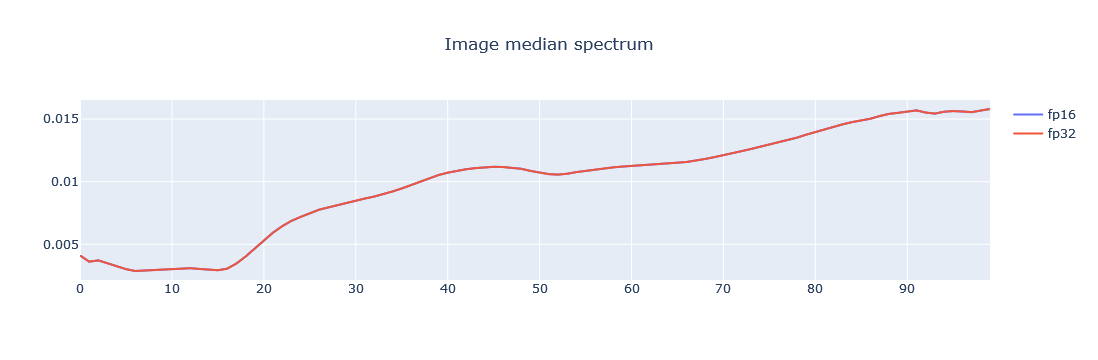

In [5]:
sample_16 = dataset_16[2]
sample_32 = dataset_32[2]
s_16 = sample_16["features"].float().reshape(-1, 100).mean(dim=0)
s_32 = sample_32["features"].reshape(-1, 100).mean(dim=0)

fig = go.Figure()
fig.add_trace(go.Scatter(y=s_16, name="fp16"))
fig.add_trace(go.Scatter(y=s_32, name="fp32"))
fig.update_layout(title_x=0.5, title_text="Image median spectrum")

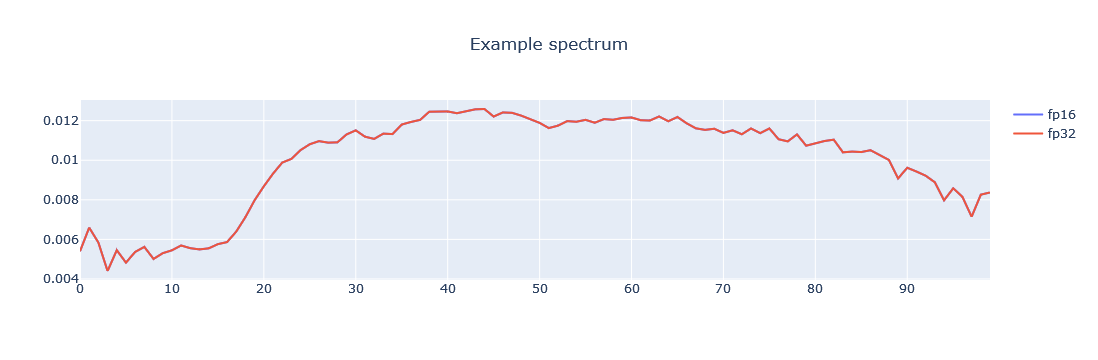

In [6]:
sample_16 = dataset_16[2]
sample_32 = dataset_32[2]
s_16 = sample_16["features"][100, 200, :]
s_32 = sample_32["features"][100, 200, :]
fig = go.Figure()
# We need to cast float16 to float32 so that plotly can understand the dtype
fig.add_trace(go.Scatter(y=s_16.float(), name="fp16"))
fig.add_trace(go.Scatter(y=s_32, name="fp32"))
fig.update_layout(title_x=0.5, title_text="Example spectrum")